# Bayesian Rule List

Implement a Bayesian Rule List model using the imodels library

Features:
- 6 meteorological features: Pressure, Relative Vorticity 850hPa, Wind Gust, Sea Surface Temperature (1000hPa), Wind Speed 850hPa, Air Density
- Samples only from Z11
- Samples only from today - previous days samples not considered

In [ ]:
!pip install imodels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
if os.getcwd() != '/content/drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset':
  os.chdir('./drive/MyDrive/Tropical_Cyclones_Thesis/ERA5_Dataset')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from datetime import timedelta

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn import metrics

# installable with: `pip install imodels`
from imodels import BayesianRuleListClassifier
from imodels.discretization import ExtraBasicDiscretizer
from imodels.discretization import BasicDiscretizer

import demo_helper

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Loading Data

In [ ]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ERA5_16zones_avg_std_10D_NoWindDirection.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from datetime import datetime

def is_exact_substring(main_string, substring):
    # Check if substring is in the main_string
    if substring in main_string:
        # Check if the substring is not followed by a digit
        index = main_string.find(substring)
        if index + len(substring) == len(main_string) or not main_string[index + len(substring)].isdigit():
            return True
    return False

def filter_features(df, feats):
  columns = df.columns
  selected_columns = []
  for col in columns:
    for feat in feats:
      if is_exact_substring(col, feat):
        selected_columns.append(col)
  return df[selected_columns]

def day_of_year(date_string):
    date_object = datetime.strptime(date_string, '%Y-%m-%d')
    return date_object.timetuple().tm_yday

selected_meteo_feat = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_1000hPa', 'Wind_850hPa', 'Wind_300hPa', 'T_1000hPa', 'Air_Density']
#selected_meteo_feat = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_850hPa', 'T_1000hPa', 'Air_Density']

selected_steps = ['-0']#, '-1', '-2', '-3']
selected_zones = ['_Z11']

print(8*4*6*2)

df_filtered = filter_features(df_era5, selected_meteo_feat)
df_filtered = filter_features(df_filtered, selected_steps)
df_filtered = filter_features(df_filtered, selected_zones)

cols = []
for elem in df_filtered.columns:
  cols.append(elem.replace('_Z11-0',''))
df_filtered.columns = cols

# Convert to list of day numbers
day_numbers = [day_of_year(date_str) for date_str in df_filtered.index]
df_filtered['yday'] = day_numbers

df_filtered

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


384


,P_Mean,P_Std,Vor_850hPa_Mean,Vor_850hPa_Std,Wind_Gust_Mean,Wind_Gust_Std,Wind_1000hPa_Mean,Wind_1000hPa_Std,Wind_850hPa_Mean,Wind_850hPa_Std,Wind_300hPa_Mean,Wind_300hPa_Std,T_1000hPa_Mean,T_1000hPa_Std,Air_Density_Mean,Air_Density_Std,yday
DATE,,,,,,,,,,,,,,,,,
1980-02-01,100839.731017,181.191942,-1.326374e-05,0.000030,9.161096,1.891302,8.030626,2.043022,8.482522,2.708363,5.320485,2.539159,298.471739,0.587952,1.160672,0.002807,32
1980-02-02,100819.805114,275.843829,-1.415175e-05,0.000042,13.511941,2.658089,10.984181,2.337932,13.300693,3.685055,9.385830,2.922391,298.590989,0.560706,1.159397,0.003655,33
1980-02-03,100624.544895,484.595148,-3.241318e-05,0.000063,14.583778,3.584316,12.698438,3.631855,15.776457,6.220648,9.869005,5.341686,298.370429,0.675645,1.158297,0.006810,34
1980-02-04,100803.244697,515.555038,-8.678676e-06,0.000079,13.257321,5.089852,10.006286,4.507314,11.668562,8.944703,9.528795,3.824716,298.688186,0.982700,1.158986,0.008253,35
1980-02-05,100982.396277,245.186655,5.546546e-06,0.000018,10.703720,3.427292,8.347398,2.595995,7.948358,5.141756,14.101187,3.314044,298.337832,0.897690,1.162109,0.005853,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101312.753918,37.618223,5.143506e-06,0.000021,4.121407,1.500981,2.490474,1.160273,2.725058,1.919368,9.128163,5.538250,298.534718,0.575989,1.164909,0.001809,361
2021-12-28,101220.225639,49.067544,-2.528924e-07,0.000024,4.851551,3.032916,3.386623,3.012908,2.221736,1.332991,13.674474,7.572192,298.337200,0.893729,1.165014,0.003450,362
2021-12-29,101050.137778,77.453997,-1.208212e-05,0.000062,8.444925,4.404138,5.737394,3.843089,4.733215,1.904213,14.903417,6.812252,297.744687,1.149675,1.165850,0.005070,363


In [ ]:
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/ibtracs_Z11.csv')
df_target = df_target.drop(columns=['Unnamed: 0'])
df_target = df_target.set_index('DATE')
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['TC_PRESENCE']

df_target

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DATE
1980-02-01    0
1980-02-02    1
1980-02-03    1
1980-02-04    0
1980-02-05    0
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: TC_PRESENCE, Length: 15310, dtype: int64

# Discretize features with pre-computed DT intervals

In [ ]:
# Vor_850hPa_Mean: -1.31857e-05 < -3.1055e-06
N_samples = df_filtered.shape[0]
vor_850hPa_mean_buckets = np.zeros((N_samples, 3))
vors = df_filtered['Vor_850hPa_Mean'].values

for i in range(N_samples):
  if vors[i] <= -1.31857e-05:
    vor_850hPa_mean_buckets[i, 0] = 1
  elif vors[i] <= -3.1055e-06 and vors[i] > -1.31857e-05:
    vor_850hPa_mean_buckets[i, 1] = 1
  elif vors[i] > -3.1055e-06:
    vor_850hPa_mean_buckets[i, 2] = 1

# Vor_850hPa_Std: 3.26144e-05 < 3.74302e-05 < 4.04935e-05 < 4.79227e-05
N_samples = df_filtered.shape[0]
vor_850hPa_std_buckets = np.zeros((N_samples, 5))
vors = df_filtered['Vor_850hPa_Std'].values

for i in range(N_samples):
  if vors[i] <= 3.26144e-05:
    vor_850hPa_std_buckets[i, 0] = 1
  elif vors[i] > 3.26144e-05 and vors[i] <= 3.74302e-05:
    vor_850hPa_std_buckets[i, 1] = 1
  elif vors[i] > 3.74302e-05 and vors[i] <= 4.04935e-05:
    vor_850hPa_std_buckets[i, 2] = 1
  elif vors[i] > 4.04935e-05 and vors[i] <= 4.79227e-05:
    vor_850hPa_std_buckets[i, 3] = 1
  elif vors[i] > 4.79227e-05:
    vor_850hPa_std_buckets[i, 4] = 1

# P_Mean: 100643.37109375 < 100919.9921875 < 101056.16796875 < 101229.4921875
N_samples = df_filtered.shape[0]
p_mean_buckets = np.zeros((N_samples, 5))
p = df_filtered['P_Mean'].values

for i in range(N_samples):
  if p[i] <= 100643.37109375:
    p_mean_buckets[i, 0] = 1
  elif p[i] > 100643.37109375 and p[i] <= 100919.9921875:
    p_mean_buckets[i, 1] = 1
  elif p[i] > 100919.9921875 and p[i] <= 101056.16796875:
    p_mean_buckets[i, 2] = 1
  elif p[i] > 101056.16796875 and p[i] <= 101229.4921875:
    p_mean_buckets[i, 3] = 1
  elif p[i] > 101229.4921875:
    p_mean_buckets[i, 4] = 1

# P_Std: 175.2408065796 < 196.7230377197
p_std_buckets = np.zeros((N_samples, 3))
p = df_filtered['P_Std'].values

for i in range(N_samples):
  if p[i] <= 175.2408065796:
    p_std_buckets[i, 0] = 1
  elif p[i] > 175.2408065796 and p[i] <= 196.7230377197:
    p_std_buckets[i, 1] = 1
  elif p[i] > 196.7230377197:
    p_std_buckets[i, 2] = 1

# Wind_Gust_Std: 2.106030345 < 4.3492689133
wind_gust_std_buckets = np.zeros((N_samples, 3))
w = df_filtered['Wind_Gust_Std'].values

for i in range(N_samples):
  if w[i] <= 2.106030345:
    wind_gust_std_buckets[i, 0] = 1
  elif w[i] > 2.106030345 and w[i] <= 4.3492689133:
    wind_gust_std_buckets[i, 1] = 1
  elif w[i] > 4.3492689133:
    wind_gust_std_buckets[i, 2] = 1

# Wind_850hPa_Mean: 11.4503893852 < 17.0275006294
wind_850hPa_mean_buckets = np.zeros((N_samples, 3))
w = df_filtered['Wind_850hPa_Mean'].values

for i in range(N_samples):
  if w[i] <= 11.4503893852:
    wind_850hPa_mean_buckets[i, 0] = 1
  elif w[i] > 11.4503893852 and w[i] <= 17.0275006294:
    wind_850hPa_mean_buckets[i, 1] = 1
  elif w[i] > 17.0275006294:
    wind_850hPa_mean_buckets[i, 2] = 1

# Wind_850hPa_Std: 5.1909511089
wind_850hPa_std_buckets = np.zeros((N_samples, 2))
w = df_filtered['Wind_850hPa_Std'].values

for i in range(N_samples):
  if w[i] <= 5.1909511089:
    wind_850hPa_std_buckets[i, 0] = 1
  elif w[i] > 5.1909511089:
    wind_850hPa_std_buckets[i, 1] = 1

# Wind_1000hPa_Mean: 7.0005607605 < 7.5408978462 < 10.5627818108
wind_1000hPa_mean_buckets = np.zeros((N_samples, 4))
w = df_filtered['Wind_1000hPa_Mean'].values

for i in range(N_samples):
  if w[i] <= 7.0005607605:
    wind_1000hPa_mean_buckets[i, 0] = 1
  elif w[i] > 7.0005607605 and w[i] <= 7.5408978462:
    wind_1000hPa_mean_buckets[i, 1] = 1
  elif w[i] > 7.5408978462 and w[i] <= 10.5627818108:
    wind_1000hPa_mean_buckets[i, 2] = 1
  elif w[i] > 10.5627818108:
    wind_1000hPa_mean_buckets[i, 3] = 1

# Air_Density_Std: 0.0031330852
air_density_std_buckets = np.zeros((N_samples, 2))
a = df_filtered['Air_Density_Std'].values

for i in range(N_samples):
  if a[i] <= 5.1909511089:
    air_density_std_buckets[i, 0] = 1
  elif a[i] > 5.1909511089:
    air_density_std_buckets[i, 1] = 1

# T_1000hPa_Std: 0.4158065617 < 0.8649717867 < 0.9198407829
N_samples = df_filtered.shape[0]
t_1000hPa_std_buckets = np.zeros((N_samples, 4))
t = df_filtered['T_1000hPa_Std'].values

for i in range(N_samples):
  if t[i] <= 0.4158065617:
    t_1000hPa_std_buckets[i, 0] = 1
  elif t[i] > 0.4158065617 and t[i] <= 0.8649717867:
    t_1000hPa_std_buckets[i, 1] = 1
  elif t[i] > 0.8649717867 and t[i] <= 0.9198407829:
    t_1000hPa_std_buckets[i, 2] = 1
  elif t[i] > 0.9198407829:
    t_1000hPa_std_buckets[i, 3] = 1

# yday: 60.0 < 320.5 < 341.0
ydays_buckets = np.zeros((N_samples, 4))
d = df_filtered['Wind_1000hPa_Mean'].values

for i in range(N_samples):
  if d[i] <= 60:
    ydays_buckets[i, 0] = 1
  elif d[i] > 60 and d[i] <= 320:
    ydays_buckets[i, 1] = 1
  elif d[i] > 320 and d[i] <= 341:
    ydays_buckets[i, 2] = 1
  elif d[i] > 341:
    ydays_buckets[i, 3] = 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
combined_array = np.hstack((vor_850hPa_mean_buckets,
                            vor_850hPa_std_buckets,
                            p_mean_buckets,
                            p_std_buckets,
                            wind_gust_std_buckets,
                            wind_850hPa_mean_buckets,
                            wind_850hPa_std_buckets,
                            wind_1000hPa_mean_buckets,
                            air_density_std_buckets,
                            t_1000hPa_std_buckets,
                            ydays_buckets))

# Vor_850hPa_Mean: -1.31857e-05 < -3.1055e-06
att_vor_850hPa_mean   = ['Vor_850hPa_Mean <= -1.32e-05',
                         '-1.32e-05 < Vor_850hPa_Mean <= -3.11e-06',
                         'Vor_850hPa_Mean >= -3.11e-06']
# Vor_850hPa_Std: 3.26144e-05 < 3.74302e-05 < 4.04935e-05 < 4.79227e-05
att_vor_850hPa_std    = ['Vor_850hPa_Std <= 3.26e-05',
                         '3.26e-05 < Vor_850hPa_Std <= 3.74e-05',
                         '3.74e-05 < Vor_850hPa_Std <= 4.05e-05',
                         '4.05e-05 < Vor_850hPa_Std <= 4.79e-05',
                         'Vor_850hPa_Std > 4.79e-05']
# P_Mean: 100643.37109375 < 100919.9921875 < 101056.16796875 < 101229.4921875
att_p_mean            = ['P_Mean <= 100643.37109375',
                         '100643 < P_Mean <= 100920',
                         '100920 < P_Mean <= 101056',
                         '101056 < P_Mean <= 101230',
                         'P_Mean > 101230']
# P_Std: 175.2408065796 < 196.7230377197
att_p_std             = ['P_Std <= 175',
                         '175 < P_Std <= 196',
                         'P_Std > 196']
# Wind_Gust_Std: 2.106030345 < 4.3492689133
att_wind_gust_std     = ['Wind_Gust_Std <= 2.11',
                         '2.11 < Wind_Gust_Std <= 4.35',
                         'Wind_Gust_Std > 4.35']
# Wind_850hPa_Mean: 11.4503893852 < 17.0275006294
att_wind_850hPa_mean  = ['Wind_850hPa_Mean <= 11.5',
                         '11.5 < Wind_850hPa_Mean <= 17.0',
                         'Wind_850hPa_Mean >= 17.0']
# Wind_850hPa_Std: 5.1909511089
att_wind_850hPa_std   = ['Wind_850hPa_Std < 5.19', 'Wind_850hPa_Std >= 5.19']
# Wind_1000hPa_Mean: 7.0005607605 < 7.5408978462 < 10.5627818108
att_wind_1000hPa_mean = ['Wind_1000hPa_Mean <= 7.0',
                         '7.0 < Wind_1000hPa_Mean <= 7.5',
                         '7.5 < Wind_1000hPa_Mean <= 10.6',
                         'Wind_1000hPa_Mean > 10.6']
# Air_Density_Std: 0.0031330852
att_air_density_std   = ['Air_Density_Std <= 0.0031', 'Air_Density_Std > 0.0031']
# T_1000hPa_Std: 0.4158065617 < 0.8649717867 < 0.9198407829
att_temp_1000hPa_std  = ['T_1000hPa_Std <= 0.42',
                         '0.42 < T_1000hPa_Std <= 0.87',
                         '0.87 < T_1000hPa_Std <= 0.92',
                         'T_1000hPa_Std > 0.92']
# yday: 60.0 < 320.5 < 341.0
att_yday              = ['yday <= 60',
                         '60 < yday <= 321',
                         '321 < yday <= 340',
                         'yday > 340']

buckets_atts = att_vor_850hPa_mean + att_vor_850hPa_std + att_p_mean + att_p_std + att_wind_gust_std + att_wind_850hPa_mean + att_wind_850hPa_std + att_wind_1000hPa_mean + att_air_density_std + att_temp_1000hPa_std + att_yday
print(len(buckets_atts))
df_buckets = pd.DataFrame(combined_array, columns=buckets_atts)
df_buckets['DATE'] = df_filtered.index.values
df_buckets = df_buckets.set_index('DATE')
print(df_buckets.columns)
df_buckets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


38
Index(['Vor_850hPa_Mean <= -1.32e-05',
       '-1.32e-05 < Vor_850hPa_Mean <= -3.11e-06',
       'Vor_850hPa_Mean >= -3.11e-06', 'Vor_850hPa_Std <= 3.26e-05',
       '3.26e-05 < Vor_850hPa_Std <= 3.74e-05',
       '3.74e-05 < Vor_850hPa_Std <= 4.05e-05',
       '4.05e-05 < Vor_850hPa_Std <= 4.79e-05', 'Vor_850hPa_Std > 4.79e-05',
       'P_Mean <= 100643.37109375', '100643 < P_Mean <= 100920',
       '100920 < P_Mean <= 101056', '101056 < P_Mean <= 101230',
       'P_Mean > 101230', 'P_Std <= 175', '175 < P_Std <= 196', 'P_Std > 196',
       'Wind_Gust_Std <= 2.11', '2.11 < Wind_Gust_Std <= 4.35',
       'Wind_Gust_Std > 4.35', 'Wind_850hPa_Mean <= 11.5',
       '11.5 < Wind_850hPa_Mean <= 17.0', 'Wind_850hPa_Mean >= 17.0',
       'Wind_850hPa_Std < 5.19', 'Wind_850hPa_Std >= 5.19',
       'Wind_1000hPa_Mean <= 7.0', '7.0 < Wind_1000hPa_Mean <= 7.5',
       '7.5 < Wind_1000hPa_Mean <= 10.6', 'Wind_1000hPa_Mean > 10.6',
       'Air_Density_Std <= 0.0031', 'Air_Density_Std > 0.0031',


,Vor_850hPa_Mean <= -1.32e-05,-1.32e-05 < Vor_850hPa_Mean <= -3.11e-06,Vor_850hPa_Mean >= -3.11e-06,Vor_850hPa_Std <= 3.26e-05,3.26e-05 < Vor_850hPa_Std <= 3.74e-05,3.74e-05 < Vor_850hPa_Std <= 4.05e-05,4.05e-05 < Vor_850hPa_Std <= 4.79e-05,Vor_850hPa_Std > 4.79e-05,P_Mean <= 100643.37109375,100643 < P_Mean <= 100920,...,Air_Density_Std <= 0.0031,Air_Density_Std > 0.0031,T_1000hPa_Std <= 0.42,0.42 < T_1000hPa_Std <= 0.87,0.87 < T_1000hPa_Std <= 0.92,T_1000hPa_Std > 0.92,yday <= 60,60 < yday <= 321,321 < yday <= 340,yday > 340
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1980-02-02,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1980-02-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1980-02-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1980-02-05,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-12-28,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2021-12-29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Generate Buckets with library function

In [ ]:
df_filtered

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,P_Mean,P_Std,Vor_850hPa_Mean,Vor_850hPa_Std,Wind_Gust_Mean,Wind_Gust_Std,Wind_1000hPa_Mean,Wind_1000hPa_Std,Wind_850hPa_Mean,Wind_850hPa_Std,Wind_300hPa_Mean,Wind_300hPa_Std,T_1000hPa_Mean,T_1000hPa_Std,Air_Density_Mean,Air_Density_Std,yday
DATE,,,,,,,,,,,,,,,,,
1980-02-01,100839.731017,181.191942,-1.326374e-05,0.000030,9.161096,1.891302,8.030626,2.043022,8.482522,2.708363,5.320485,2.539159,298.471739,0.587952,1.160672,0.002807,32
1980-02-02,100819.805114,275.843829,-1.415175e-05,0.000042,13.511941,2.658089,10.984181,2.337932,13.300693,3.685055,9.385830,2.922391,298.590989,0.560706,1.159397,0.003655,33
1980-02-03,100624.544895,484.595148,-3.241318e-05,0.000063,14.583778,3.584316,12.698438,3.631855,15.776457,6.220648,9.869005,5.341686,298.370429,0.675645,1.158297,0.006810,34
1980-02-04,100803.244697,515.555038,-8.678676e-06,0.000079,13.257321,5.089852,10.006286,4.507314,11.668562,8.944703,9.528795,3.824716,298.688186,0.982700,1.158986,0.008253,35
1980-02-05,100982.396277,245.186655,5.546546e-06,0.000018,10.703720,3.427292,8.347398,2.595995,7.948358,5.141756,14.101187,3.314044,298.337832,0.897690,1.162109,0.005853,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101312.753918,37.618223,5.143506e-06,0.000021,4.121407,1.500981,2.490474,1.160273,2.725058,1.919368,9.128163,5.538250,298.534718,0.575989,1.164909,0.001809,361
2021-12-28,101220.225639,49.067544,-2.528924e-07,0.000024,4.851551,3.032916,3.386623,3.012908,2.221736,1.332991,13.674474,7.572192,298.337200,0.893729,1.165014,0.003450,362
2021-12-29,101050.137778,77.453997,-1.208212e-05,0.000062,8.444925,4.404138,5.737394,3.843089,4.733215,1.904213,14.903417,6.812252,297.744687,1.149675,1.165850,0.005070,363


In [ ]:
# Uniform  -> Equal bins length
# Quantile -> Equal number of samples in each variable
# K-Means  -> Values in each bin have the same nearest center of a 1D k-means cluster

num_bins = 6
features_list = list(df_filtered.columns)
X = df_filtered.values
print('Number of bins on all features: ', num_bins*len(features_list))
disc = ExtraBasicDiscretizer(dcols=features_list, n_bins=num_bins, strategy='uniform') # strategy = 'uniform', 'quantile', 'kmeans'
df_buckets = disc.fit_transform(pd.DataFrame(X, columns = features_list))
df_buckets.index = df_filtered.index
df_buckets

In [ ]:
import re

intervals = []
feature = 'Wind_Gust_Mean'
for elem in df_buckets.columns:
  if feature in elem:
    matches = re.findall(r'[-+]?\d*\.\d+|\d+', elem.replace('_'+feature, ''))
    float_values = [float(match) for match in matches]
    intervals.append(float_values)

intervals_list = []
for elem in intervals:
  intervals_list.append(elem[0])
intervals_list.append(intervals[-1][1])

print(intervals)
print(intervals_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


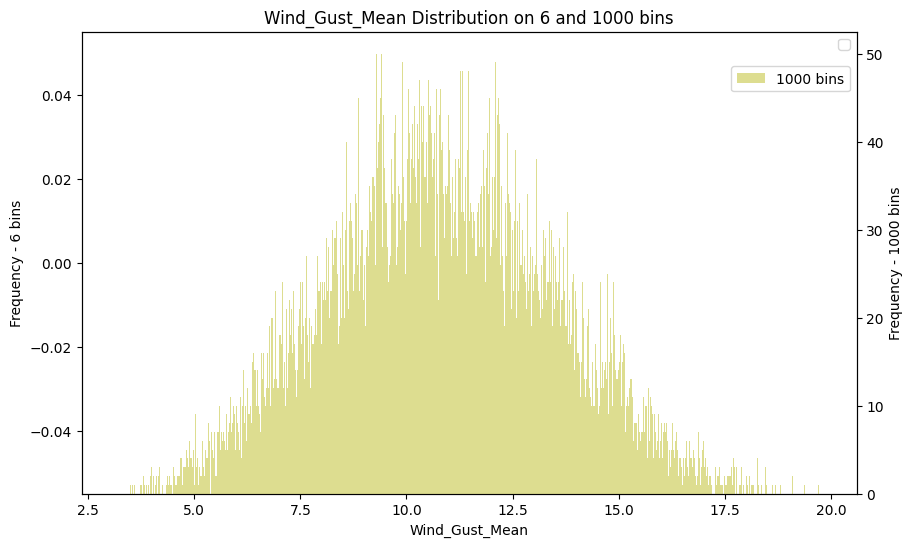

Values of bins for 6 bins:
Intervals             :  []
Bin Edges             :  []
Bin Counts            :  []
MAX val (hPa)         :  19.773405971020967
MIN val (hPa)         :  3.1757447180507348
Uniform BIN len (hPa) :  2.766276875495039
Total number of sample:  15310
Sum of samples in bins:  0.0


In [ ]:
p_mean = df_filtered[feature].values

# Create the first subplot and plot the first histogram with 6 bins
n_bins_1 = num_bins
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the histogram with manually defined bin intervals
counts_1, edges_1, _ = plt.hist(p_mean, bins=intervals_list, color='C0', edgecolor='black', alpha=0.8, label='{} bins'.format(n_bins_1))
ax1.set_xlabel('{}'.format(feature))
ax1.set_ylabel('Frequency - {} bins'.format(n_bins_1))

# Create the second subplot and plot the second histogram with 1000 bins
ax2 = ax1.twinx()
n_bins_2 = 1000
counts_2, edges_2, _ = ax2.hist(p_mean, bins=n_bins_2, alpha=0.5, color='C8', label='{} bins'.format(n_bins_2))
ax2.set_ylabel('Frequency - {} bins'.format(n_bins_2))

# Adding title
plt.title('{} Distribution on {} and {} bins'.format(feature, n_bins_1, n_bins_2))

# Display the legend for both subplots
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.94))

# Display the plot
plt.show()

# Extract values of bins
print("Values of bins for {} bins:".format(n_bins_1))
print('Intervals             : ', intervals)
print("Bin Edges             : ", list(edges_1))
print("Bin Counts            : ", counts_1)
print('MAX val (hPa)         : ', np.max(p_mean))
print('MIN val (hPa)         : ', np.min(p_mean))
print('Uniform BIN len (hPa) : ', (np.max(p_mean)-np.min(p_mean))/n_bins_1 )
print('Total number of sample: ', len(df_filtered))
print('Sum of samples in bins: ', np.sum(counts_1))

# Train-Test Splitting

In [ ]:
#################################################################
###################### TRAINING SET #############################
df_X_train = df_buckets[df_buckets.index < '2012']
df_y_train = df_target[df_target.index < '2012']
X_train = df_X_train.values
y_train = df_y_train.values
y_train = np.where(y_train > 0, 1, y_train) # If S.IndAll is greater than 0 -> a cyclone is present
y_train = y_train.reshape(1,-1)[0]

#################################################################
######################### TEST SET ##############################
df_X_test = df_buckets[df_buckets.index > '2012']
df_y_test = df_target[df_target.index > '2012']
X_test = df_X_test.values
y_test = df_y_test.values
y_test = np.where(y_test > 0, 1, y_test) # If S.IndAll is greater than 0 -> a cyclone is present
y_test = y_test.reshape(1,-1)[0]

print('ORIGINAL DATASET SIZE: ', len(df_buckets))
print('TRAINING: ', X_train.shape, y_train.shape)
print('    ---> Positive Class: ', np.count_nonzero(y_train))
print('TESTING: ', X_test.shape, y_test.shape)
print('    ---> Positive Class: ', np.count_nonzero(y_test))

ORIGINAL DATASET SIZE:  15310
TRAINING:  (11657, 38) (11657,)
    ---> Positive Class:  532
TESTING:  (3653, 38) (3653,)
    ---> Positive Class:  169


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Bayesian Rule List

In [ ]:
X_train.shape, df_buckets.columns.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((11657, 38), (38,))

In [ ]:
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
import time

# Record the start time
start_time = time.time()

print('Training...')
model = BayesianRuleListClassifier()

# model = BayesianRuleListClassifier(
#     listlengthprior=5,  # Increase this value to encourage longer lists
#     listwidthprior=5,   # You can also increase this value to encourage wider rules
#     maxcardinality=5,   # Maximum number of predicates in a rule
#     minsupport=0.2,     # Minimum support for itemsets
#     alpha=[1, 1],       # Prior hyperparameter for multinomial pseudocounts
#     n_chains=6,         # Number of MCMC chains for inference
#     max_iter=50000,     # Maximum number of iterations
#     class1label="class 1",  # Label for the positive class
#     verbose=True,       # Verbose output
#     random_state=42     # Random seed
# )

model.fit(X_train, y_train, feature_names=df_buckets.columns)
# Record the end time
end_time = time.time()
# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")
model

Training...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Training time: 545.2305970191956 seconds


Trained RuleListClassifier 
============================
IF P_Mean > 101230 > 0.5 and Wind_Gust_Std <= 2.11 > 0.5 THEN probability of class 1: 0.3% (0.2%-0.5%)
ELSE IF P_Mean > 101230 > 0.5 and Vor_850hPa_Std <= 3.26e-05 > 0.5 THEN probability of class 1: 0.6% (0.2%-1.1%)
ELSE IF P_Std <= 175 > 0.5 and Vor_850hPa_Mean >= -3.11e-06 > 0.5 THEN probability of class 1: 2.2% (1.5%-3.0%)
ELSE IF Vor_850hPa_Std <= 3.26e-05 > 0.5 THEN probability of class 1: 10.7% (8.6%-13.1%)
ELSE IF P_Mean > 101230 > 0.5 and T_1000hPa_Std > 0.92 > 0.5 THEN probability of class 1: 6.0% (2.5%-11.0%)
ELSE IF Vor_850hPa_Mean >= -3.11e-06 > 0.5 THEN probability of class 1: 26.4% (15.6%-38.9%)
ELSE IF P_Std <= 175 > 0.5 THEN probability of class 1: 29.4% (22.2%-37.1%)
ELSE IF -1.32e-05 < Vor_850hPa_Mean <= -3.11e-06 > 0.5 THEN probability of class 1: 55.8% (48.5%-62.9%)
ELSE IF Wind_850hPa_Mean <= 11.5 > 0.5 THEN probability of class 1: 82.8% (75.6%-88.9%)
ELSE IF P_Std > 196 > 0.5 THEN probability of class 1: 97.8% (94.8%-99.5%)
ELSE probability of class 1: 33.3% (1.3%-84.2%)
===========================

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


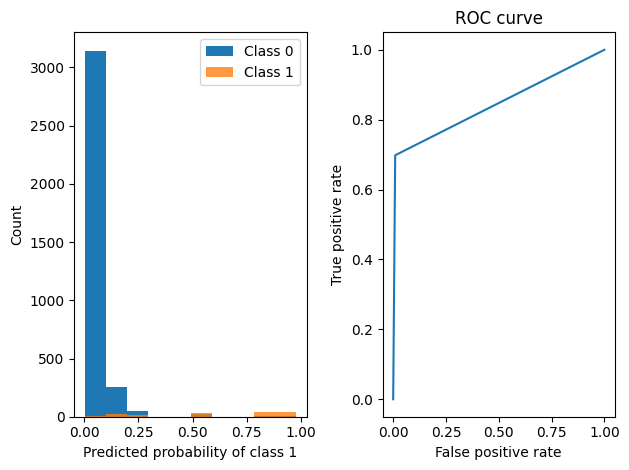

In [ ]:
probs = model.predict_proba(X_test)
demo_helper.viz_classification_preds(probs, y_test)

In [ ]:
predictions = model.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import random
idx = random.randint(0, X_test.shape[0])
print('Idx: ', idx)
print('Real target: ', y_test[idx])
print('Predicted prob: ', predictions[idx])

print(y_test.shape, predictions.shape)

y_pred = []
for elem in predictions:
  if elem[0] >= elem[1]:
    y_pred.append(0)
  else:
    y_pred.append(1)

Idx:  2619
Real target:  1
Predicted prob:  [0.02173913 0.97826087]
(3653,) (3653, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Evaluate Metrics and Rule List

In [38]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# Evaluate the model
accuracy  = accuracy_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'
precision = precision_score(y_test, y_pred, average='binary')
recall    = recall_score(y_test, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'

# Print the evaluation metrics
print(f"Accuracy    : {accuracy:.2f}")
print(f"F1 Score    : {f1:.2f}")
print(f"Recall      : {recall:.2f}")
print(f"Precision   : {precision:.2f}")

N_test = len(y_test)
fp = 0
n_cyclones_predicted = np.count_nonzero(y_pred)
n_cyclones = np.count_nonzero(y_test)

for i in range(N_test):
  if y_test[i] == 0 and y_pred[i] == 1:
    fp += 1

far = fp/n_cyclones_predicted
print(f"N TC        : {n_cyclones}")
print(f"TC predicted: {n_cyclones_predicted}")
print(f"FAR         : {far:.2f}")

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_, )
# disp.plot()
# plt.show()

Accuracy    : 0.98
F1 Score    : 0.74
Recall      : 0.70
Precision   : 0.78
N TC        : 169
TC predicted: 151
FAR         : 0.22


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
uniform_metrics  = {'Accuracy'    : 0.98,
                    'F1'    	    : 0.71,
                    'Recall'      : 0.62,
                    'FAR'         : 0.17
                    }
quantile_metrics = {'Accuracy'    : 0.97,
                    'F1'    	    : 0.71,
                    'Recall'      : 0.69,
                    'FAR'         : 0.28
                    }
kmeans_metrics   = {'Accuracy'    : 0.97,
                    'F1'    	    : 0.69,
                    'Recall'      : 0.62,
                    'FAR'         : 0.21
                    }

uniform_preds  = {'#TC'        	: 169,
                 'TC_predicted' : 126}
quantile_preds = {'#TC'        	: 169,
                  'TC_predicted': 160}
kmeans_preds   = {'#TC'        	: 169,
                  'TC_predicted': 132}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


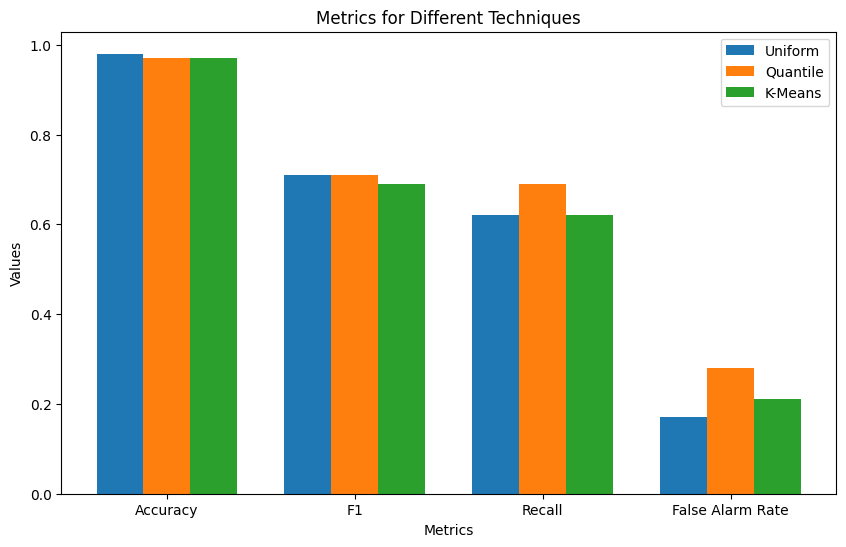

In [ ]:
# Data
techniques = ['Uniform', 'Quantile', 'K-Means']
metrics = list(uniform_metrics.keys())

# Plotting
bar_width = 0.25
index = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index - bar_width, [uniform_metrics[metric] for metric in metrics], bar_width, label='Uniform', color='C0')
bar2 = ax.bar(index, [quantile_metrics[metric] for metric in metrics], bar_width, label='Quantile', color='C1')
bar3 = ax.bar(index + bar_width, [kmeans_metrics[metric] for metric in metrics], bar_width, label='K-Means', color='C2')

# Adding labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Metrics for Different Techniques')
ax.set_xticks(index)
ax.set_xticklabels(['Accuracy', 'F1', 'Recall', 'False Alarm Rate'])
ax.legend()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


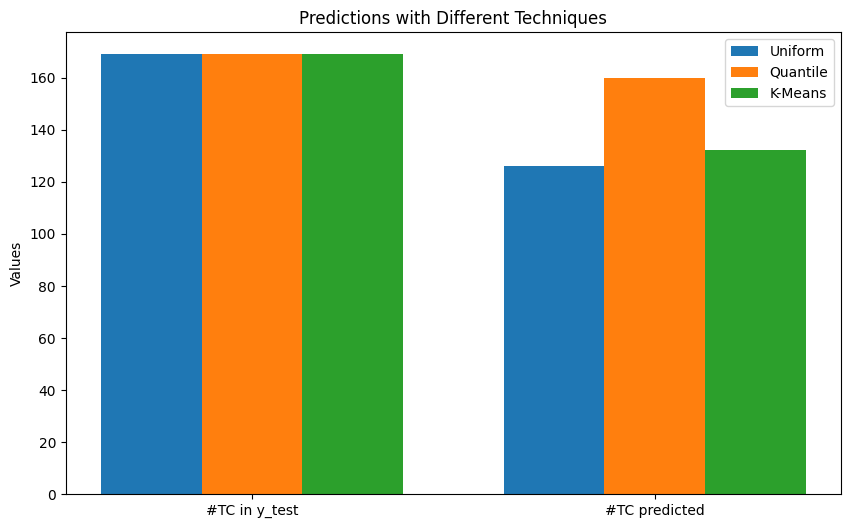

In [ ]:
# Data
techniques = ['Uniform', 'Quantile', 'K-Means']
metrics = list(uniform_preds.keys())

# Plotting
bar_width = 0.25
index = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index - bar_width, [uniform_preds[metric] for metric in metrics], bar_width, label='Uniform', color='C0')
bar2 = ax.bar(index, [quantile_preds[metric] for metric in metrics], bar_width, label='Quantile', color='C1')
bar3 = ax.bar(index + bar_width, [kmeans_preds[metric] for metric in metrics], bar_width, label='K-Means', color='C2')

# Adding labels
ax.set_ylabel('Values')
ax.set_title('Predictions with Different Techniques')
ax.set_xticks(index)
ax.set_xticklabels(['#TC in y_test', '#TC predicted'])
ax.legend()

# Show the plot
plt.show()

In [ ]:
model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Trained RuleListClassifier 
============================
IF P_Mean > 101230 > 0.5 and Wind_Gust_Std <= 2.11 > 0.5 THEN probability of class 1: 0.3% (0.2%-0.5%)
ELSE IF P_Mean > 101230 > 0.5 and Vor_850hPa_Std <= 3.26e-05 > 0.5 THEN probability of class 1: 0.6% (0.2%-1.1%)
ELSE IF P_Std <= 175 > 0.5 and Vor_850hPa_Mean >= -3.11e-06 > 0.5 THEN probability of class 1: 2.2% (1.5%-3.0%)
ELSE IF Vor_850hPa_Std <= 3.26e-05 > 0.5 THEN probability of class 1: 10.7% (8.6%-13.1%)
ELSE IF P_Mean > 101230 > 0.5 and T_1000hPa_Std > 0.92 > 0.5 THEN probability of class 1: 6.0% (2.5%-11.0%)
ELSE IF Vor_850hPa_Mean >= -3.11e-06 > 0.5 THEN probability of class 1: 26.4% (15.6%-38.9%)
ELSE IF P_Std <= 175 > 0.5 THEN probability of class 1: 29.4% (22.2%-37.1%)
ELSE IF -1.32e-05 < Vor_850hPa_Mean <= -3.11e-06 > 0.5 THEN probability of class 1: 55.8% (48.5%-62.9%)
ELSE IF Wind_850hPa_Mean <= 11.5 > 0.5 THEN probability of class 1: 82.8% (75.6%-88.9%)
ELSE IF P_Std > 196 > 0.5 THEN probability of class 1: 97.8% (94.8%-99.5%)
ELSE probability of class 1: 33.3% (1.3%-84.2%)
===========================